# LigthGBM

In [1]:
import pandas as pd
from tsm.evaluators import k_fold_validator
from sklearn.metrics import mean_squared_error
from math import sqrt
import joblib
import lightgbm as lgb

In [2]:
import matplotlib.pyplot as plt

In [3]:
SEED = 42
ROUNDS = 25000
EARLY_STOP = 10
V_ROUNDS = 1000

In [6]:
METER = 3

### Preparing Data

In [7]:
data = pd.read_pickle('data/prep/train_meter_{}.pkl'.format(METER))

In [8]:
exclude = ['timestamp', 'day_suspicious', 'month_suspicious']
y_col = ['log_meter_reading']
x_cols = [x for x in list(data) if x not in exclude + y_col]

Remove only actual 0s

In [33]:
data = data[data.log_meter_reading > 0]

### Model Training

In [34]:
lgb_reg_params = {'objective':'regression',  'boosting_type':'gbdt', 'metric':'rmse',
                  'n_jobs':-1, 'learning_rate':0.05, 'max_depth':-1,
                  'tree_learner':'serial', 'colsample_bytree': 0.7, 'subsample_freq': 1,
                  'subsample':0.5, 'max_bin': 255, 'verbose': 0, 'seed': SEED}
                  # 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}

In [35]:
%%time
for tr_idx, ts_idx in k_fold_validator(k=8, data=data.index.values, shuffle=True, random_state=42):
    
    x = data[x_cols].values
    y = data[y_col].values
    x_tr, x_ts, y_tr, y_ts = x[tr_idx], x[ts_idx], y[tr_idx], y[ts_idx]
    
    lgb_train = lgb.Dataset(x_tr, y_tr.ravel())
    lgb_eval = lgb.Dataset(x_ts, y_ts.ravel())
    lgb_reg = lgb.train(lgb_reg_params, lgb_train, valid_sets=(lgb_train, lgb_eval),
        num_boost_round=ROUNDS,early_stopping_rounds=EARLY_STOP,verbose_eval=V_ROUNDS)
    break

Training until validation scores don't improve for 10 rounds
[1000]	training's rmse: 0.580622	valid_1's rmse: 0.602295
[2000]	training's rmse: 0.525929	valid_1's rmse: 0.561068
[3000]	training's rmse: 0.495039	valid_1's rmse: 0.541324
[4000]	training's rmse: 0.473346	valid_1's rmse: 0.528995
[5000]	training's rmse: 0.456103	valid_1's rmse: 0.520045
Early stopping, best iteration is:
[5628]	training's rmse: 0.446877	valid_1's rmse: 0.515951
CPU times: user 28min 56s, sys: 9.5 s, total: 29min 6s
Wall time: 1min 50s


### Saving Model

In [54]:
rmsle = 0.515951
lgb_reg.save_model('data/models/met{}_lgb_no9s_rmsle_{}.txt'.format(METER, round(rmsle, 3)), num_iteration=lgb_reg.best_iteration)

### Error Analysis

In [37]:
%%time
data['y_hat'] = lgb_reg.predict(data[x_cols].values, num_iteration=lgb_reg.best_iteration)

CPU times: user 8min 59s, sys: 832 ms, total: 8min 59s
Wall time: 35 s


In [38]:
data['errors'] = abs(data.log_meter_reading - data.y_hat)

In [39]:
data.groupby('building_id')['errors'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
building_id,,,,,,,,
203,8692.0,0.063757,0.064664,0.000029,0.022251,0.048023,0.086888,1.193995
213,8781.0,0.080700,0.074316,0.000030,0.030303,0.062910,0.109487,1.258593
209,8722.0,0.082573,0.077964,0.000008,0.028690,0.062978,0.114256,1.142063
212,8432.0,0.083118,0.092271,0.000002,0.029497,0.063346,0.113647,4.203479
247,8781.0,0.087144,0.120401,0.000003,0.029535,0.063296,0.112930,2.410895
...,...,...,...,...,...,...,...,...
1011,2973.0,0.710923,0.602111,0.000154,0.257308,0.562147,0.998339,4.578398
244,858.0,0.744790,0.481555,0.003794,0.417071,0.695643,1.046769,3.229814
1253,8532.0,0.857390,1.101794,0.000115,0.132541,0.353627,1.126722,6.726201


In [76]:
BID = 1021
bid_data = data[data.building_id == BID].reset_index(drop=True)

AttributeError: 'DataFrame' object has no attribute 'errors_1B1M'

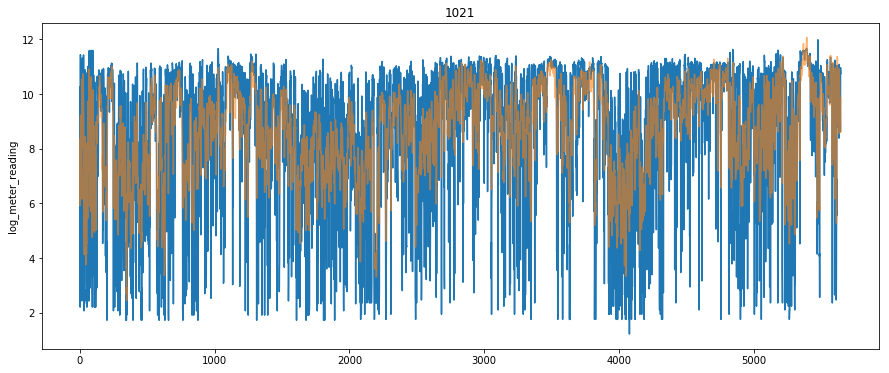

In [78]:
plt.figure(figsize=(15,6))
plt.title(BID)
plt.ylabel('log_meter_reading')
plt.plot(bid_data.log_meter_reading, label='Actual')
plt.plot(bid_data.y_hat, label='Predicted', alpha=0.6)
plt.plot(bid_data.errors_1B1M, label='Predicted Fine Tuned', alpha=0.6)
plt.legend()
plt.show()

In [79]:
SEED = 42
ROUNDS = 25000
EARLY_STOP = 100
V_ROUNDS = 10

In [80]:
%%time
for tr_idx, ts_idx in k_fold_validator(k=8, data=bid_data.index.values, shuffle=True, random_state=42):
    
    x = bid_data[x_cols].values
    y = bid_data[y_col].values
    x_tr, x_ts, y_tr, y_ts = x[tr_idx], x[ts_idx], y[tr_idx], y[ts_idx]
    
    lgb_train = lgb.Dataset(x_tr, y_tr.ravel())
    lgb_eval = lgb.Dataset(x_ts, y_ts.ravel())
    lgb_reg_bid = lgb.train(lgb_reg_params, lgb_train, valid_sets=(lgb_train, lgb_eval),
                        init_model='data/models/met3_lgb_no9s_rmsle_0.516.txt',
                        num_boost_round=ROUNDS,early_stopping_rounds=EARLY_STOP,verbose_eval=V_ROUNDS)
    break

Training until validation scores don't improve for 100 rounds
[5630]	training's rmse: 1.51204	valid_1's rmse: 1.55256
[5640]	training's rmse: 1.47777	valid_1's rmse: 1.55216
[5650]	training's rmse: 1.44593	valid_1's rmse: 1.55298
[5660]	training's rmse: 1.41884	valid_1's rmse: 1.55799
[5670]	training's rmse: 1.39163	valid_1's rmse: 1.56234
[5680]	training's rmse: 1.36773	valid_1's rmse: 1.56354
[5690]	training's rmse: 1.34306	valid_1's rmse: 1.56487
[5700]	training's rmse: 1.32241	valid_1's rmse: 1.56614
[5710]	training's rmse: 1.30161	valid_1's rmse: 1.57022
[5720]	training's rmse: 1.28021	valid_1's rmse: 1.56993
[5730]	training's rmse: 1.26034	valid_1's rmse: 1.57342
[5740]	training's rmse: 1.24122	valid_1's rmse: 1.57712
Early stopping, best iteration is:
[5645]	training's rmse: 1.4612	valid_1's rmse: 1.55085
CPU times: user 13.8 s, sys: 84 ms, total: 13.9 s
Wall time: 878 ms


In [ ]:
%%time
bid_data['y_hat_1B1M'] = lgb_reg_bid.predict(bid_data[x_cols].values, num_iteration=lgb_reg_bid.best_iteration)

In [71]:
bid_data['errors_1B1M'] = abs(bid_data.log_meter_reading - bid_data.y_hat_1B1M)

In [73]:
bid_data[['errors', 'errors_1B1M']].describe()

,errors,errors_1B1M
count,8532.000000,8532.000000
mean,0.857390,0.856316
std,1.101794,1.100236
min,0.000115,0.000056
25%,0.132541,0.132963
50%,0.353627,0.352768
75%,1.126722,1.124505
max,6.726201,6.675648


In [74]:
original_data = pd.read_pickle('data/prep/train_meter_{}.pkl'.format(METER))

In [83]:
or_bid_data = original_data[original_data.building_id == BID].reset_index(drop=True)

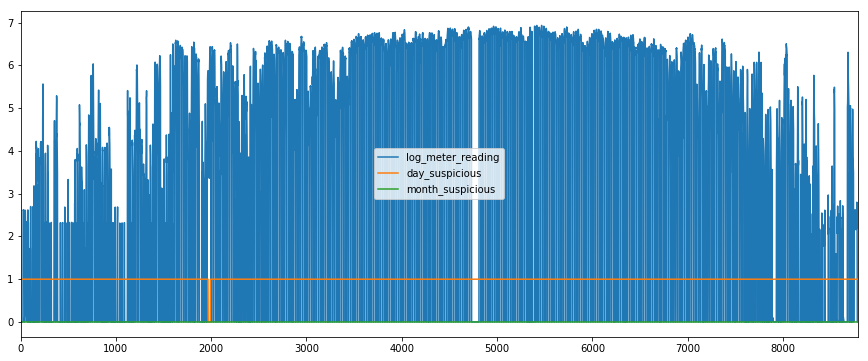

In [84]:
or_bid_data[['log_meter_reading', 'day_suspicious', 'month_suspicious']].plot(figsize=(15,6))